In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

In [5]:
#data load 
df = pd.read_csv('Train.csv', encoding = 'cp949')
df.head()
validation = pd.read_csv('Validation.csv', encoding = 'cp949')
test = pd.read_csv('Test.csv', encoding = 'cp949')

## 변수 설명
1. Movie : 영화 제목

2. Playdate : 개봉 날짜
   Play_month : 개봉 월
   Weekdays : 개봉 요일

3. Rep_Nationality : 대표 국가

4. Grade : 관람 등급

5. Rep_production : 대표 제작사
   Prod_grade : 제작사 등급
   Prod_avg_grade : 제작사 평균 등급
                    (제작사는 시나리오 선정, 투자자 물색, 배우 캐스팅 등의 역할을 맡는다.
                     따라서 배우 등급, 배급사 등급, 감독 등급, 영화 평점 등을 반영하여 계산하였다.)

6. Rep_distribution : 대표 배급사
   Dist_grade : 배급사 등급
                (우리나라의 경우 배급사가 메인 투자자인 경우가 많으며, 배급사가 스크린을 얼마나 확보하느냐에 따라 영화의 성과가 결정된다.
                 따라서 배급사에 따른 개봉 첫째주의 스크린 수를 파악하여 이를 배급사의 등급으로 대체하였다.)

7. Rep_genre : 대표 장르

8. Rep_director : 대표 감독
   Direc_avg_grade : 감독 평균 등급
                     (감독 등급은 2년간 감독한 영화의 평균 평점으로 대체하였다.

9. Rep_actor1 : 대표 배우1
   Actor1_grade : 대표 배우1 등급
   Rep_actor2 : 대표 배우2
   Actor2_grade : 대표 배우2 등급
   Rep_actor3 : 대표 배우3
   Actor3_grade : 대표 배우3 등급
   Rep_actor4 : 대표 배우4
   Actor4_grade : 대표 배우4 등급
   Rep_actor5 : 대표 배우5
   Actor5_grade : 대표 배우5 등급
                  (배우의 등급은 2년간 배우가 출연한 영화들의 2주차 평균 누적관객수를 변환한 값이다.)

10. Critic_star : 평론가 평점

11. Netizen_star_before_play : 개봉 전 네티즌 평점
    Num_of_participants_before_play : 개봉 전 평가 참여 인원

12. Netizen_star_after_play : 개봉 후 네티즌 평점

13. Diff_netizen_star : 개봉 전/후 평점 차이

14. Expect_index_wannasee : 개봉 전 기대지수(보고싶어요)
    Expect_index_notreally : 개봉 전 기대지수(글쎄요)
    Ratio_notreally : 글쎼요 비율

15. Week1_isplay : 1주차 상영 여부
    Week1_playdays : 1주차 상영일수
    Week1_holiday : 1주차 공휴일수(주말 포함)
    Week1_sales : 1주차 매출액
    Week1_sales_share : 1주차 매출액 점유율
    Week1_audience : 1주차 관객수
    Week1_screen : 1주차 스크린수
    Week1_Screening : 1주차 상영횟수

## 과제 

킹스맨2  0927 개봉
남한산성 0930 개봉
넛잡 1003 개봉


**데이터를 기준으로 킹스맨2, 남한산성 => 1주차 데이터 안 스고 2주차 누적 관객 맞추기, 넛잡 => 1주차 데이터 안쓰고 1주차 누적관객수 맞추기 **

각각에 대한 모델링을 따로 할필요가 있다. 



In [6]:
#파생 변수 생성 
df.colum

AttributeError: 'DataFrame' object has no attribute 'colums'

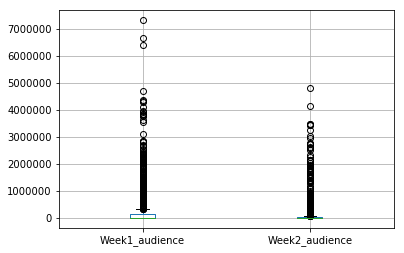

In [3]:
#예측 변수에 대한 시각화
import matplotlib.pyplot as plt 

audience_list = ['Week'+str(i)+'_audience' for i in range(1,3)]
audience_data = df[audience_list]

audience_data.boxplot()
plt.show()
#관객수가 1주차가 좀더 많은 것을 볼수 있다.

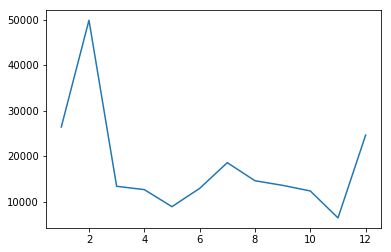

In [6]:
#각 범주형 범수에 대해 파생변수를 생성한다. 
#1. Playdate 
#개봉일의 경우 개봉일에 따라 관객수에 영향을 끼친다는 것은 말이 되지 않는다고 판단하였다. 
#하지만 개봉일에 연휴가 낀 경우등 다른 변수에 의해 이 변수가 유의해질 수 있다고 생각했다. 
#그렇지만 연휴 등 다른 변수의 영향을 고려하기 위해 이에 해당하는 변수를 생성하기는 적합하지 
#않다고 판단하여 이를 설명변수에서 제외하기로 했다. 

#2. Playmonth 
#개봉월에 대한 정보이다. 이 데이터를 활용하여 영화 관객수의 계절성을 파악해볼 수 있을 것이라고 
#기대한다. 
#따라서 개봉월에 따른 첫주차 관객의 수를 평균으로 한 plot을 그려보고 계절성을 파악한다. 
temp = df[['Play_month', 'Week1_audience']]
temp = temp.groupby(['Play_month'], as_index = False).median()
#outlier로 정보가 왜곡될수 있으므로 median을 이용하여 aggregate한다. 
plt.plot(temp['Play_month'],temp['Week1_audience'])
plt.show()
#겨울 방학 시즌의 관객수가 많은 것을 볼 수 있다.

In [17]:
# 3. Weekdays 
#개봉일의 요일 정보를 담고 있다. 
#개봉일 요일 정보는 첫째주 관객수와 관련되어 있을 수 있다는 생각이 들어 이를 확인해본다.

temp = df[['Weekdays', 'Week1_audience']]
temp = temp.groupby(['Weekdays'], as_index = False).median()
print(temp)
#단순히 결과를 보면 수목이 월등하게 많기 때문에 어느정도 관련이 있다고 생각할 수 있지만 
#데이터를 살펴보니 수,목에 해당하지 않는 영화는 59개만 존재함을 알 수 있다. 
#따라서 단순히 이 결과만을 보고 개봉요일이 영화관객수에 영향을 끼친다고 판단하기 어렵다
#따라서 이를 삭제한다.

  Weekdays  Week1_audience
0      금요일           528.0
1      목요일          7624.0
2      수요일        102588.5
3      월요일           252.0
4      일요일           552.0
5      토요일           200.0
6      화요일         14689.5


In [18]:
# 4. Rep_Nationality
#영화의 대표국적을 나타낸다. 대표국적은 꽤 영향을 끼치수 있다고 생각했다. 
#왜냐하면 우리나라는 스크린쿼터제가 적용되고 있는 나라중 하나이기 때문이다. 
#스크린쿼터제란 미국 및 유럽 영화들의 지나친 비중과 상영횟수를 방지하여 한국여화를 보호하는 
#법으로 규제화한 것이다.
nation_temp = df[['Movie','Rep_Nationality','Week5_Cum_audience']]
nation_temp.groupby(['Rep_Nationality'], as_index = False).count()
nation_temp1= nation_temp.groupby(['Rep_Nationality'], as_index=False).agg({'Movie':'count','Week5_Cum_audience':'median'})

In [19]:
nation_temp1
#대표국적의 경우 미국/캐나다/호주권 영화와 한국권 영화가 강세를 가지고 있음을 알 수 있다.

,Rep_Nationality,Movie,Week5_Cum_audience
0,기타,107,7742.0
1,독일/영국/프랑스,157,7366.0
2,미국/캐나다/호주,349,69101.0
3,일본/중국,166,11127.0
4,한국,304,54753.5


In [20]:
# 5. Grade 
#영화 관람등급을 나타내는 변수이다. 관람등급의 경우 청소년 불가 관람이 있다면 
#대상 관객수가 확연히 줄어드는 변수이다. 따라서 이 변수가 어느정도 영향을 끼칠 수 있다고 생각하낟. 
grade_temp = df[['Movie','Grade','Week5_Cum_audience']]
grade_temp1 = grade_temp.groupby(['Grade'],as_index=False).median()

In [21]:
grade_temp1
#청소년 관람불가의 관객수가 매우 높음을 알 수 있다.

,Grade,Week5_Cum_audience
0,12세이상관람가,22469.5
1,15세이상관람가,17712.0
2,전체관람가,14993.0
3,청소년관람불가,76082.0


In [22]:
# 6. Rep_production
#제작사의 경우 시나리오 선택, 배우 캐스팅, 투자자 물색 등의 역할을 한다. 
#따라서 제작사의 힘을 힘을 나타내기 위해 배우 배급사 감독 등을 반영하도록 한다. 



In [30]:
# 7. Rep_distribution
# 대표 배급사 배급사의 경우 스크린의 수를 이용하여 관련 변수를 생성하도록 한다. 
temp_dist = df[['']]

Index(['Movie', 'Playdate', 'Play_month', 'Weekdays', 'Rep_Nationality',
       'Grade', 'Rep_production', 'Rep_distributor', 'Rep_genre',
       'Rep_director', 'Rep_actor1', 'Rep_actor2', 'Rep_actor3', 'Rep_actor4',
       'Rep_actor5', 'Critic_star', 'Netizen_star_before_play',
       'Num_of_participants_before_play', 'Netizen_star_after_play',
       'Expect_index_wannasee', 'Expect_index_notreally', 'Week1_isplay',
       'Week1_playdays', 'Week1_holiday', 'Week1_sales', 'Week1_sales_share',
       'Week1_audience', 'Week1_screen', 'Week1_screening', 'Week2_isplay',
       'Week2_holiday', 'Week2_sales', 'Week2_sales_share', 'Week2_audience',
       'Week2_screen', 'Week2_screening', 'Week3_holiday', 'Week4_holiday',
       'Week2_Cum_audience', 'Week3_Cum_audience', 'Week4_Cum_audience',
       'Week5_Cum_audience', 'year'],
      dtype='object')

In [24]:
# 8. Rep_genre 
#장르에 따른 1주차 관객수를 시각화해보도록 한다. 

In [25]:
# 9. Rep_direcxtor 
# 감독의 경우 영화의 평균 평점을 이용하여 파생 변수를 생성하도록 하낟. 

In [26]:
# 10. Rep_actor 
# 배우 역시 감독과 같이 평균 평점을 이용하여 파생 변수를 생성한다. 


In [27]:
# 11. Critic star 
# 평론가 평점은 그대로 이용해보도록 한다. 

In [28]:
# 12 ~
#이후 평점은 그대로 사용한다. 